In [1]:
import pandas as pd
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import ZeroPadding2D, BatchNormalization, AveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


### Preprocessing

In [2]:
def get_data(data_frame):
    imgs = []
    
    for i, row in data_frame.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = (band_1 + band_2)/2
        
        imgs.append(np.dstack((band_1, band_2, band_3)))
        
    return np.array(imgs)

In [3]:
def get_norm_params(data):
    
    return [
           (data[:,:,:,0].min(), data[:,:,:,0].max(), data[:,:,:,0].mean()), 
           (data[:,:,:,1].min(), data[:,:,:,1].max(), data[:,:,:,1].mean()),
           (((data[:,:,:,0] + data[:,:,:,1])/2).min(), 
           ((data[:,:,:,0] + data[:,:,:,1])/2).max(), 
           ((data[:,:,:,0] + data[:,:,:,1])/2).mean())
           ]

In [4]:
def normalize(data, params):
    
    # p = (min, max, mean)
    p1 = params[0]
    p2 = params[1]
    p3 = params[2]
    
    data[:, :, :, 0] = (data[:, :, :, 0] - p1[2]) / (p1[1] - p1[0])
    data[:, :, :, 1] = (data[:, :, :, 1] - p2[2]) / (p2[1] - p2[0])
    data[:, :, :, 2] = (data[:, :, :, 2] - p3[2]) / (p3[1] - p3[0])

    return data

### Plot

In [5]:
def show_all_bands(data, current):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.imshow(data[current, :, :, 0])
    ax1.set_title("Band 1")

    ax2.imshow(data[current, :, :, 1])
    ax2.set_title("Band 2")
    
    ax3.imshow(data[current, :, :, 2])
    ax3.set_title("Band 3")

    plt.show()

### Model

In [22]:
def get_model():    
    inputs = Input(shape=(75, 75, 3))

    # prep
    x = ZeroPadding2D((3, 3))(inputs)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # conv block 1, shortcut with conv layer
    input_tensor = x

    x = Conv2D(64, (1, 1), strides=(1, 1),
               name='conv_1a')(input_tensor)
    x = BatchNormalization(axis=3, name='batch_1a')(x)
    x = Activation('relu')(x)

    x = Conv2D(64, 3, padding='same',
               name='conv_1b')(x)
    x = BatchNormalization(axis=3, name='batch_1b')(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (1, 1), name='conv_1c')(x)
    x = BatchNormalization(axis=3, name='batch_1c')(x)

    shortcut = Conv2D(256, (1, 1), strides=(1,1),
                      name='shortcut1')(input_tensor)
    shortcut = BatchNormalization(axis=3, name='batch1')(shortcut)

    x = keras.layers.add([x, shortcut])
    x = Activation('relu')(x)

    # identity block 1, shortcut without conv layer
    input_tensor = x

    x = Conv2D(64, (1, 1), name='conv_2a')(input_tensor)
    x = BatchNormalization(axis=3, name='batch_2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(64, 3,
               padding='same', name='conv_2b')(x)
    x = BatchNormalization(axis=3, name='batch_2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (1, 1), name='conv_2c')(x)
    x = BatchNormalization(axis=3, name='batch_2c')(x)

    x = keras.layers.add([x, input_tensor])
    x = Activation('relu')(x)

    # identity block 2, shortcut without conv layer
    input_tensor = x

    x = Conv2D(64, (1, 1), name='conv_3a')(input_tensor)
    x = BatchNormalization(axis=3, name='batch_3a')(x)
    x = Activation('relu')(x)

    x = Conv2D(64, 3,
               padding='same', name='conv_3b')(x)
    x = BatchNormalization(axis=3, name='batch_3b')(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (1, 1), name='conv_3c')(x)
    x = BatchNormalization(axis=3, name='batch_3c')(x)

    x = keras.layers.add([x, input_tensor])
    x = Activation('relu')(x)

    # there could be many more blocks

    # final stage
    x = AveragePooling2D((6, 6), strides=(6, 6), name='avg_pool')(x)
    x = Flatten()(x)

    predictions = Dense(1, activation='sigmoid')(x)

    # this creates a model that includes
    # the Input layer and three Dense layers
    model = Model(input=inputs, output=predictions)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### Load the data

In [23]:
df_train = pd.read_json('train.json')  # load pd dataframe

In [24]:
Y = np.array(df_train['is_iceberg'])  # extract labels

In [25]:
X = get_data(df_train)  # convert to [1603, 75, 75, 3]

In [26]:
del df_train

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [28]:
del X, Y

In [29]:
params = get_norm_params(X_train)

In [30]:
X_train = normalize(X_train, params=params)
X_test = normalize(X_test, params=params)

In [31]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1203, 75, 75, 3)
(1203,)
(401, 75, 75, 3)
(401,)


In [32]:
print(X_test[:, :, :, 0].mean())

-0.00405939303139


### Set parameters

In [33]:
batch_size = 32
epochs = 40

### Pray to Hinton

In [34]:
datagen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0, # tego nie testowalem
                         height_shift_range = 0, # tego nie testowale
                         channel_shift_range=0, # slabe efekty daje, moze trzeba lepiej dobrac wartosc
                         zoom_range = 0.1,
                         rotation_range = 10)

In [35]:
model = get_model()

/home/gabriel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [36]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 81, 81, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 38, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 38, 38, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [37]:
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                   verbose=1, epsilon=1e-4, mode='min')

In [38]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                            steps_per_epoch=len(X_train)/batch_size, epochs=epochs, callbacks=[reduce_lr_loss],
                            validation_data=(X_test,Y_test))

Epoch 1/40
38/37 [==============================] - 10s 256ms/step - loss: 0.5869 - acc: 0.7236 - val_loss: 0.7152 - val_acc: 0.4589
Epoch 2/40
38/37 [==============================] - 7s 184ms/step - loss: 0.3943 - acc: 0.8130 - val_loss: 0.7012 - val_acc: 0.4339
Epoch 3/40
38/37 [==============================] - 7s 180ms/step - loss: 0.3785 - acc: 0.8347 - val_loss: 0.7928 - val_acc: 0.4589
Epoch 4/40
38/37 [==============================] - 7s 180ms/step - loss: 0.3414 - acc: 0.8459 - val_loss: 0.7063 - val_acc: 0.4988
Epoch 5/40
38/37 [==============================] - 7s 179ms/step - loss: 0.2905 - acc: 0.8725 - val_loss: 0.7418 - val_acc: 0.4788
Epoch 6/40
38/37 [==============================] - 7s 183ms/step - loss: 0.2843 - acc: 0.8665 - val_loss: 0.8221 - val_acc: 0.4040
Epoch 7/40
38/37 [==============================] - 7s 184ms/step - loss: 0.2839 - acc: 0.8673 - val_loss: 0.9383 - val_acc: 0.4663
Epoch 8/40
37/37 [============================>.] - ETA: 0s - loss: 0.2604 

Na kagglu jakieś 0.18 wyszło. Trzeba rozsądniej dobrać parametry, trochę pozmieniałem, ale część jest zostawiona w takiej formiej, w jakiej to posklejałem z różnych źródeł.

### Plot learning process

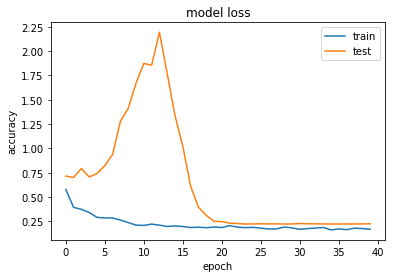

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

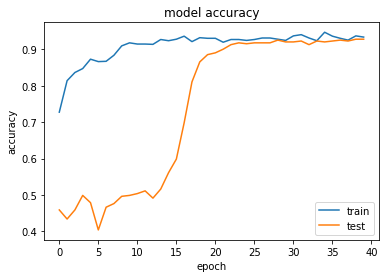

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### Test

In [41]:
del X_test, Y_test, X_train, Y_train

In [42]:
df_test = pd.read_json('test.json')

In [43]:
ID = df_test['id']
X = get_data(df_test)

In [44]:
del df_test

In [45]:
X = normalize(X, params)

In [46]:
print(X[:,:,:,1].mean())

0.0253777990384


In [47]:
pred = model.predict(X)

In [48]:
print(pred)

[[ 0.02356728]
 [ 0.95852178]
 [ 0.00916142]
 ..., 
 [ 0.01026784]
 [ 0.99946076]
 [ 0.99976844]]


In [49]:
submission = pd.DataFrame()
submission['id'] = ID
submission['is_iceberg'] = pred
submission.to_csv('4_Dec.csv', index=False)